<h1> Analisis Sentimen terhadap Kebijakan Mobil Listrik </h1>

Mengkaji sentimen publik bersumber dari Twitter mengenai topik mobil listrik dan kebijakannya di Indonesia.

# 0 - Persiapan

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from collections import Counter

import re
import nltk

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, classification_report

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

from lime import lime_text
from lime.lime_text import LimeTextExplainer

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to C:\Users\Annisa Sekar
[nltk_data]     Tierra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df1 = pd.read_excel("Tweet Data.xlsx")
df1.head()

,username,tweet_url,full_text,Label
0,RIlahi2,https://x.com/RIlahi2/status/1753363971141468216,Misalnya...subsidi motor atau mobil listrik dialihkan buat beli ini kira kira sungai2 kita tambah ciamik...,-1
1,kumparan,https://x.com/kumparan/status/1792359877412839526,Berita populer kumparanOTO Minggu (19/5) estimasi harga mobil listrik Hyundai Kona dampak fitur fast charging mobil listrik. #kumparanOTO https://t.co/VhRBvZsX0G,-1
2,kompascom,https://x.com/kompascom/status/1776415415599849947,Ketika kesehatan baterai mobil listrik turun di bawah 70 persen akan diganti gratis oleh Vinfast. https://t.co/lJ3fg5XScL,1
3,5teV3n_Pe9eL,https://x.com/5teV3n_Pe9eL/status/1795972841806115191,@kumparan Yo jelas mikir2 lah konsumen namanya bekas batere rawan soak kalo batere ude soak harganya bisa setengah harga beli,0
4,afannni,https://x.com/afannni/status/1786958550818074883,@AzzamIzzulhaq pak apakah ada tanggapan untuk informasi di cuitan ini? https://t.co/AOjI3zcssM,0


In [3]:
df1["tweet"] = df1.full_text
df1["Emotion"] = df1.Label
df1.drop(columns=["Label", "full_text", 'username','tweet_url'], inplace=True)

df1.head()

,tweet,Emotion
0,Misalnya...subsidi motor atau mobil listrik dialihkan buat beli ini kira kira sungai2 kita tambah ciamik...,-1
1,Berita populer kumparanOTO Minggu (19/5) estimasi harga mobil listrik Hyundai Kona dampak fitur fast charging mobil listrik. #kumparanOTO https://t.co/VhRBvZsX0G,-1
2,Ketika kesehatan baterai mobil listrik turun di bawah 70 persen akan diganti gratis oleh Vinfast. https://t.co/lJ3fg5XScL,1
3,@kumparan Yo jelas mikir2 lah konsumen namanya bekas batere rawan soak kalo batere ude soak harganya bisa setengah harga beli,0
4,@AzzamIzzulhaq pak apakah ada tanggapan untuk informasi di cuitan ini? https://t.co/AOjI3zcssM,0


In [4]:
df1['Emotion'] = df1['Emotion'].replace({
    -1: 0,
    0: 1,
    1: 2
})

# 1 - Pemahaman Data

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    378 non-null    object
 1   Emotion  378 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.0+ KB


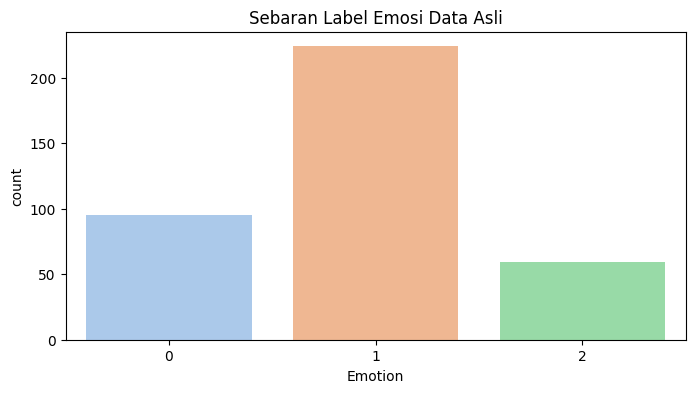

In [6]:
# Sebaran Label Data
plt.figure(figsize=(8,4))
sns.countplot(x = 'Emotion', data = df1, palette='pastel')
plt.title('Sebaran Label Emosi Data Asli')
plt.show()

Dimiliki data hasil labelisasi manual dari data scrapping twitter. Total datanya adalah 378 data dimana kelas label didominasi memiliki emosi 1 (netral) diikuti dengan emosi negatif (0) dan emosi positif (2)

# 2 - Pre processing

## Test Cleaning

Di bagian ini akan dihapuskan beberapa elemen teks yang tidak berhubungan dengan tweet yang akan diklasifikasikan.

In [7]:
def clean_text(text):
    # Menghapus username
    text = re.sub(r'@\w+', '', text)

    # Menghapus tag
    text = re.sub(r'#\w+', '', text)

    # Hapus teks dalam []
    text = re.sub(r'\[\w+]', '', text)

    # Menghapus URL
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\b\w+(?:com|org)\b', '', text)
    
    # Menghapuskan ... dan memastikan spasi
    text = re.sub(r'\.{2,}', ' ', text)

    # Menambahkan spasi di antara tanda baca dan teks yang berurutan tanpa spasi
    text = re.sub(r'([^\w\s])([^\w\s])', r'\1 \2', text)
    text = re.sub(r'([^\w\s])(\w)', r'\1 \2', text)
    text = re.sub(r'(\w)([^\w\s])', r'\1 \2', text)

    # Penghapusan karakter yang bukan alfanumerik kecuali tanda baca
    text = re.sub(r'[^\w\s]', '', text)

    # Menghapus karakter numerik
    text = re.sub(r'\d+', '', text)

    # Menyeragamkan teks menjadi huruf kecil
    text = text.lower()

    # Menghapus whitespace berlebih
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    return text


In [8]:
# Menerapkan pada dataset
df1_clean = df1.copy()
df1_clean.tweet = df1_clean.tweet.apply(clean_text)

# Menampilkan data sebelum dan sesudah cleaning
display(df1.head(), df1_clean.head())

,tweet,Emotion
0,Misalnya...subsidi motor atau mobil listrik dialihkan buat beli ini kira kira sungai2 kita tambah ciamik...,0
1,Berita populer kumparanOTO Minggu (19/5) estimasi harga mobil listrik Hyundai Kona dampak fitur fast charging mobil listrik. #kumparanOTO https://t.co/VhRBvZsX0G,0
2,Ketika kesehatan baterai mobil listrik turun di bawah 70 persen akan diganti gratis oleh Vinfast. https://t.co/lJ3fg5XScL,2
3,@kumparan Yo jelas mikir2 lah konsumen namanya bekas batere rawan soak kalo batere ude soak harganya bisa setengah harga beli,1
4,@AzzamIzzulhaq pak apakah ada tanggapan untuk informasi di cuitan ini? https://t.co/AOjI3zcssM,1


,tweet,Emotion
0,misalnya subsidi motor atau mobil listrik dialihkan buat beli ini kira kira sungai kita tambah ciamik,0
1,berita populer kumparanoto minggu estimasi harga mobil listrik hyundai kona dampak fitur fast charging mobil listrik,0
2,ketika kesehatan baterai mobil listrik turun di bawah persen akan diganti gratis oleh vinfast,2
3,yo jelas mikir lah konsumen namanya bekas batere rawan soak kalo batere ude soak harganya bisa setengah harga beli,1
4,pak apakah ada tanggapan untuk informasi di cuitan ini,1


Akan dicek secara random hasil text cleaning apaah sudah cukup membersihkan teks atau belum.

In [9]:
rnd = random.randint(1, 10000)
display(df1.sample(n=10, random_state=rnd), df1_clean.sample(n=10, random_state=rnd))

# Setelah melakukan beberapa apengecekan secara random didapatan bahwa hasil preprocessing sudah cukup baik


,tweet,Emotion
24,@detikcom Jgn sok kaget lah..masa gak kenal perilaku bangsa sendiri?,0
297,Menteri Bahlil Sebut Pabrik Baterai Mobil Listrik Pertama di RI Siap Produksi https://t.co/qjFRA9WWQs #Ramadan https://t.co/sKjqg2j8Yr,1
212,@AzzamIzzulhaq dan sekarang sisa 30%an engineer anak muda di badan usaha tsb karena minimnya atensi stakeholdernya sisanya generasi senior yg menunggu masa pensiunnya.,1
56,@AzzamIzzulhaq Ya klo tidak di korup maling berdasi.. ya pasti udah ada semua itu ustad,1
332,NJOP tanah 2024 naik 100%++ wkwkw Buat bayarin IKN laknat sama mukbang siang gratis Miskin sekalian dapet bansos Kaya sekalian dapet subsidi mobil listrik dan jalan tol Warga kelas menengah pake motor emang target palak negara,0
42,@detikcom Opung kan sangat tahu tesla luar dalam Karena ketidakmampuan tenaga negeri konoha maka investasi tesla di kasih ke india,2
361,@kumparan jangankan mobil motor listrik aja susah trganjal harga batery yg mahal kl udah soak.kl bisa pake batery alkaline mah beli dah.....,0
211,@ridwanhr Pak gub gak ada ya mobil murah2 yg bs diangsur ringan buat operasional yayasan tahun ke tiga nih antar jemput anak2 panti utk kursus make mobil pinjaman,1
87,@NOTASLIMBOY Masa depan itu Mobil H2.,2
103,@kumparan Berarti konsumennya pinter. Trend mobil listrik nggak akan lama. Mirip2 mobil BBG yg dulu heboh juga sekarang sudah nggak ada.,0


,tweet,Emotion
24,jgn sok kaget lah masa gak kenal perilaku bangsa sendiri,0
297,menteri bahlil sebut pabrik baterai mobil listrik pertama di ri siap produksi,1
212,dan sekarang sisa an engineer anak muda di badan usaha tsb karena minimnya atensi stakeholdernya sisanya generasi senior yg menunggu masa pensiunnya,1
56,ya klo tidak di korup maling berdasi ya pasti udah ada semua itu ustad,1
332,njop tanah naik wkwkw buat bayarin ikn laknat sama mukbang siang gratis miskin sekalian dapet bansos kaya sekalian dapet subsidi mobil listrik dan jalan tol warga kelas menengah pake motor emang target palak negara,0
42,opung kan sangat tahu tesla luar dalam karena ketidakmampuan tenaga negeri konoha maka investasi tesla di kasih ke india,2
361,jangankan mobil motor listrik aja susah trganjal harga batery yg mahal kl udah soak kl bisa pake batery alkaline mah beli dah,0
211,pak gub gak ada ya mobil murah yg bs diangsur ringan buat operasional yayasan tahun ke tiga nih antar jemput anak panti utk kursus make mobil pinjaman,1
87,masa depan itu mobil h,2
103,berarti konsumennya pinter trend mobil listrik nggak akan lama mirip mobil bbg yg dulu heboh juga sekarang sudah nggak ada,0


## Text Pre-Processing

Selanjutnya akan dihapuskan beberapa stop word dan mengganti kata-kata non baku sehingga dapat meningkatkan akurasi model.

> ### Kamus Slang Words

In [10]:
# kamus 1
sl1 = {"@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "tuku": "beli", "batre" : "baterai", "batere" : "baterai", "baterei" : "baterai", "batrei" : "baterai",  "batrenya" : "baterai", 'antri' : 'antre', 'batery': "baterai", "tolol": "bodoh", "ri":"indonesia", 'brangkat':'berangkat', "stock":"stok", "ngomong":'bicara', 'quality':'kualitas', 'kwalitas':'kualitas', 'stasiun isi' : 'spklu', 'kendara':'kendaraan', 'hahaha' : 'tertawa'}

# kamus2
sl2 = pd.read_csv("https://raw.githubusercontent.com/haryoa/indo-collex/main/dict/inforformal-formal-Indonesian-dictionary.tsv", sep="\t")
sl2.set_index("informal", drop=True, inplace=True)
sl2 = sl2.to_dict()["formal"]
sl2

# kamus 3
sl3 = pd.read_csv("https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt", sep="\t", header=None)
sl3.set_index(0, drop=True, inplace=True)
sl3 = sl3.to_dict()[1]

# menggabungkan semua kamus slang words
sl_word = {**sl1, **sl2, **sl3}

print(dict(list(sl_word.items())[1:10]))

{'abis': 'habis', 'ad': 'ada', 'adlh': 'adalah', 'afaik': 'as far as i know', 'ahaha': 'haha', 'aj': 'saja', 'ajep-ajep': 'dunia gemerlap', 'ak': 'saya', 'akika': 'aku'}


> ### Kamus Stopwords

In [11]:
# kamus 1: sastrawi
factory = StopWordRemoverFactory()
sw_id1 = factory.get_stop_words()

# kamus 2
sw_id2 = pd.read_csv("https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt",header=None)
sw_id2 = list(sw_id1[0])

# kamus 3
sw_id3 = ['kalau', 'terus', 'cont', 'iya','deh', 'eh', 's', 'rang', 'sih', 'sebentar', 'mah',
          'maksud', 'banget', 'kayak', 'tet', 'h','e', 'kali', 'tot', 'nya', 'also',
          'ba', 'anjing', 's']

# kamus 4
sw_id4 = pd.read_csv("https://raw.githubusercontent.com/nolimitid/nolimit-kamus/master/indonesian-stopwords-complete.txt",header=None)
sw_id4 = list(sw_id4[0])

# Menggabungkan
sw_id = sw_id1 + sw_id2 + sw_id3 + sw_id4

# Menghapus duplikasi dengan mengubahnya menjadi set
sw_id = set(sw_id)

sw_id = list(sw_id)
sw_id[:20]

['tiba-tiba',
 'mengingat',
 'baru',
 'kalian',
 'masing-masing',
 'begitukah',
 'sejumlah',
 'sekecil',
 'berturut-turut',
 'memperbuat',
 'sebesar',
 'selagi',
 'ditunjuk',
 'kamilah',
 'bolehkah',
 'bakalan',
 'nanti',
 'sela',
 'sehingga',
 'akan']

Kamus *slang word* dan *stop word* diperbarui berkala setiap kali melakukan visualisasi *wordcloud*. Apabila masih nampak beberapa kata yang tidak mencerminkan topik atau merupakan *slang/stop word* maka kata tersebut akan ditambahkan pada kamus.

In [12]:
# Fungsi untuk menghapus stopword
def stopwords_removal(words,stopword):
    return [word for word in words if word not in stopword]

def preprocess_text(text, slang_words = sl_word, sw = sw_id):
    # Slang Words
    text = ' '.join([slang_words.get(word, word) for word in text.split()])

    # Stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = stemmer.stem(text)

    # Stop Words
    text = text.split()
    text = " ".join(stopwords_removal(text, sw))

    return text

In [13]:
# Menerapkan pada dataset
df1_pre = df1_clean.copy()
df1_pre.tweet = df1_pre.tweet.apply(preprocess_text)

Selanjutnya secara random dilakukan pengeecekan terhadap hasil penghapusan slang word.

In [14]:
rnd = random.randint(1, 10000)
display(df1.sample(n=6, random_state=rnd), df1_clean.sample(n=6, random_state=rnd), df1_pre.sample(n=6, random_state=rnd))

# Setelah melakukan beberapa pengecekan secara random didapatan bahwa hasil preprocessing sudah cukup baik

,tweet,Emotion
124,@worksfess Menguntungkan banget kalo pake mobil listrik ga pusing mikirin ganjil genap apa lagi Wuling BingouEv,2
319,Teknologi Baterai Terbaru Pangkas Waktu Charging Kendaraan Listrik Teknologi yang mampu meningkatkan jangkauan sekaligus mengurangi waktu pengisian daya kendaraan listrik akan segera diadopsi oleh banyak mobil. https://t.co/LO5J5WOvva #detikinet,1
55,@investorgabut Ada podcast dr orang mekaniknya. Better untuk short term period ini mending pilih hybrid instead of full EV. Karena spare part yang sulit di EV dan kalo rusak 1 komponen kelistrikan bisa seharga mobil itu sendiri.,0
45,Pengalaman Mengisi Daya Mobil Listrik di SPKLU PLN: Mudah dan Cepat https://t.co/s3J51iAAZO,2
10,@lhayesno Kalau ilustrasi pemakaiannya 6 tahun kabar bagus buat kita semua: orang kaya dan/atau kaum mendang mending akan segera ganti mobil dalam 5 tahun pemakaian.,1
17,@kompascom harganya jauh dibawah kompetitor nya nih kalo dari lihat lgsg kemaren di iims sama di gi build quality nya oke banget cloud ev tinggal test drive nya di PEVS 2024 biar ada experience nyetirnya,2


,tweet,Emotion
124,menguntungkan banget kalo pake mobil listrik ga pusing mikirin ganjil genap apa lagi wuling bingouev,2
319,teknologi baterai terbaru pangkas waktu charging kendaraan listrik teknologi yang mampu meningkatkan jangkauan sekaligus mengurangi waktu pengisian daya kendaraan listrik akan segera diadopsi oleh banyak mobil,1
55,ada podcast dr orang mekaniknya better untuk short term period ini mending pilih hybrid instead of full ev karena spare part yang sulit di ev dan kalo rusak komponen kelistrikan bisa seharga mobil itu sendiri,0
45,pengalaman mengisi daya mobil listrik di spklu pln mudah dan cepat,2
10,kalau ilustrasi pemakaiannya tahun kabar bagus buat kita semua orang kaya dan atau kaum mendang mending akan segera ganti mobil dalam tahun pemakaian,1
17,harganya jauh dibawah kompetitor nya nih kalo dari lihat lgsg kemaren di iims sama di gi build quality nya oke banget cloud ev tinggal test drive nya di pevs biar ada experience nyetirnya,2


,tweet,Emotion
124,untung pakai mobil listrik pusing pikir ganjil genap wuling bingouev,2
319,teknologi baterai pangkas charging kendara listrik teknologi tingkat jangkau isi daya kendara listrik adopsi mobil,1
55,podcast orang mekanik better short term period pilih hybrid instead full ev spare part sulit ev rusak komponen listrik harga mobil,0
45,alam isi daya mobil listrik spklu pln mudah cepat,2
10,ilustrasi pakai kabar bagus orang kaya kaum dang ganti mobil pakai,1
17,harga kompetitor lihat langsung kemarin iims build kualitas oke cloud ev tinggal test drive pevs biar experience nyetirnya,2


# 4 - Analisis Klasifikasi

Akan diterapkan metode cross validation dengan KFolds untuk pembentukan model.

In [15]:
kf = KFold(n_splits=5, random_state = 42, shuffle = True)

In [16]:
# Gunakan data yang telah di cleaning dan melewati tahap pre-processing
df2 = df1_pre.copy()
df2.head()

,tweet,Emotion
0,subsidi motor mobil listrik alih beli sungai ciamik,0
1,berita populer kumparanoto minggu estimasi harga mobil listrik hyundai kona dampak fitur fast charging mobil listrik,0
2,sehat baterai mobil listrik turun persen ganti gratis vinfast,2
3,pikir konsumen nama bekas baterai rawan soak baterai ude soak harga harga beli,1
4,tanggap informasi cuit,1


Pemodelan akan dilakukan dengan mencoba berbagai metode yang menghasilkan nilai F1 weighted terbesar.

#### Tanpa resampling

In [17]:
# Splitting Data
X = df2.copy()
y = X.pop("Emotion")

# Split data menjadi train, validation, dan test set
X_train, X_test, y_train, y_test = train_test_split(X.tweet, y, test_size = 0.2, random_state = 0, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0, stratify = y_train)

display(X_train.shape, X_test.shape, X_val.shape)

(241,)

(76,)

(61,)

In [18]:
def train_model(model, data, targets):
    text_clf = Pipeline([('vect', TfidfVectorizer()),
                         ('clf', model)])

    text_clf.fit(data, targets)
    return text_clf

def weighted_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

weighted_f1_scorer = make_scorer(weighted_f1)

# Model-model
def train_model_comparison(models, X_train, y_train, X_val, y_val):
    results = []
    for name, model in models.items():
        text_clf = train_model(model, X_train, y_train)

        # Cross Validation
        cv_scores = cross_val_score(text_clf, X_train, y_train, cv = kf, scoring = weighted_f1_scorer)
        train_acc = cv_scores.mean()

        # Memprediksi
        val_pred = text_clf.predict(X_val)

        # Menghitung F1 Weighted
        val_acc = f1_score(y_val, val_pred, average = 'weighted')

        results.append([name, train_acc, val_acc])

    # DataFrame dari hasil
    df_results = pd.DataFrame(results, columns=['Model', 'Train F1 weighted', 'Val F1 weighted'])
    df_results_sorted = df_results.sort_values(by='Val F1 weighted', ascending=False)

    return df_results_sorted

In [19]:
# Kandidat model
models = {
    'Random Forest': RandomForestClassifier(random_state = 42),
    'Logistic Regression': LogisticRegression(random_state = 42),
    'Decision Tree': DecisionTreeClassifier(random_state = 42),
    'SVM': SVC(random_state = 42),
    'Naive Bayes': MultinomialNB(),
    'XGBoost': XGBClassifier(random_state = 42)
}

results = train_model_comparison(models, X_train, y_train, X_val, y_val)
print(results)

                 Model  Train F1 weighted  Val F1 weighted
3                  SVM           0.484110         0.534008
1  Logistic Regression           0.531885         0.498289
0        Random Forest           0.523841         0.486736
4          Naive Bayes           0.444963         0.473361
5              XGBoost           0.566981         0.411448
2        Decision Tree           0.537401         0.405216


Dari keluaran di atas kandidat model terbaik adalah SVM, Naive bayes, dan Logistic regression. Selanjutnya akan dicoba tuning menggunakan ketiga model tersebut.

##### Hyperparameter-Tuning untuk SVC

In [20]:
# Membuat pipeline dengan TfidfVectorizer dan model SVM
svm_model = Pipeline([('vect', TfidfVectorizer()), ('clf', SVC(random_state = 42))])

# Daftar hyperparameter yang ingin dituning
param_grid = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'clf__C': (1, 10, 100),
    'clf__kernel': ('linear', 'rbf'),
}

# Inisialisasi GridSearchCV dengan model, parameter grid, dan metrik evaluasi yang diinginkan
svm_grid = GridSearchCV(svm_model, param_grid, cv = kf, n_jobs = -1, verbose = 1, scoring = weighted_f1_scorer)

# Melatih GridSearchCV pada data train
svm_grid.fit(X_train, y_train)

# Menampilkan parameter terbaik dan F1 weighted nya
print("Best parameters found: ", svm_grid.best_params_)
print("Train F1 weighted: ", svm_grid.best_score_)

svm_best = svm_grid.best_estimator_
y_pred = svm_best.predict(X_val)
print("Val F1 weighted: ", f1_score(y_val, y_pred, average = 'weighted'))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'clf__C': 10, 'clf__kernel': 'linear', 'vect__max_df': 0.75, 'vect__ngram_range': (1, 1)}
Train F1 weighted:  0.5818211351390884
Val F1 weighted:  0.5545498660252759


Hasil *hyperparameter tuning* untuk SVC tanpa resamplingtidak begitu mengindikasikan adanya *overfitting*.

##### Hyperparameter-Tuning Random Forest

In [21]:
# Membuat pipeline dengan TfidfVectorizer dan model Random Forest
rf_model = Pipeline([('vect', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state = 42))])

# Daftar hyperparameter yang ingin dituning
param_grid = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
}

# Inisialisasi GridSearchCV dengan model, parameter grid, dan metrik evaluasi yang diinginkan
rf_grid = GridSearchCV(rf_model, param_grid, cv = kf, n_jobs = -1, verbose = 1, scoring = weighted_f1_scorer)

# Melatih GridSearchCV pada data train
rf_grid.fit(X_train, y_train)

# Menampilkan parameter terbaik dan F1 weighted nya
print("Best parameters found: ", rf_grid.best_params_)
print("Train F1 weighted: ", rf_grid.best_score_)

rf_best = rf_grid.best_estimator_
y_pred = rf_best.predict(X_val)
print("Val F1 weighted: ", f1_score(y_val, y_pred, average = 'weighted'))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters found:  {'clf__max_depth': None, 'clf__n_estimators': 300, 'vect__max_df': 0.5, 'vect__ngram_range': (1, 2)}
Train F1 weighted:  0.5499866157831058
Val F1 weighted:  0.4473632233853446


Hasil *hyperparameter tuning* untuk SVC tanpa resampling mengindikasikan terdapat *overfitting* yang lebih kuat dibandingkan SVC.

##### Hyperparameter-Tuning Regresi Logistik

In [22]:
# Membuat pipeline dengan TfidfVectorizer dan model SVM
lr_model = Pipeline([('vect', TfidfVectorizer()),
                         ('clf', LogisticRegression(random_state = 42))])

# Daftar hyperparameter yang ingin dituning
param_grid = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__solver': ['liblinear', 'saga'],
    'clf__max_iter': [100, 200, 300]
}


# Inisialisasi GridSearchCV dengan model, parameter grid, dan metrik evaluasi yang diinginkan
lr_grid = GridSearchCV(lr_model, param_grid, cv = kf, n_jobs = -1, verbose = 1, scoring = weighted_f1_scorer)

# Melatih GridSearchCV pada data train
lr_grid.fit(X_train, y_train)

# Menampilkan parameter terbaik dan F1 weighted nya
print("Best parameters found: ", lr_grid.best_params_)
print("Train F1 weighted: ", lr_grid.best_score_)

lr_best = lr_grid.best_estimator_
y_pred = lr_best.predict(X_val)
print("Val F1 weighted: ", f1_score(y_val, y_pred, average = 'weighted'))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters found:  {'clf__C': 100, 'clf__max_iter': 100, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Train F1 weighted:  0.61410014895656
Val F1 weighted:  0.5307643176495636


Hasil *hyperparameter tuning* untuk Logistic Regression tanpa resampling mengindikasikan terdapat sedikit *overfitting*.

#### Resampling dengan SMOTE tomek

Resampling dianggap diperlukan karena terdapat imbalance class pada data train

In [23]:
# Splitting Data
X = df2.copy()
y = X.pop("Emotion")

# Split data menjadi train, validation, dan test set
X_train, X_test, y_train, y_test = train_test_split(X.tweet, y, test_size = 0.2, random_state = 0, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0, stratify = y_train)

display(X_train.shape, X_test.shape, X_val.shape)

(241,)

(76,)

(61,)

In [24]:
# Membuat pipeline modeling
def train_model(model, data, targets):
    text_clf = ImbPipeline([('vect', TfidfVectorizer()),
                         ('resample', SMOTETomek(random_state=0)),
                         ('clf', model)])
    
    text_clf.fit(data, targets)
    return text_clf

def weighted_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

weighted_f1_scorer = make_scorer(weighted_f1)

# Model-Model
def train_model_comparison(models, X_train, y_train, X_val, y_val):
    results = []
    for name, model in models.items():
        text_clf = train_model(model, X_train, y_train)

        # Cross-validation
        cv_scores = cross_val_score(text_clf, X_train, y_train, cv = kf, scoring=weighted_f1_scorer)
        train_acc = cv_scores.mean()

        # Memprediksi
        val_pred = text_clf.predict(X_val)

        # F1 Weighted
        val_acc = f1_score(y_val, val_pred, average='weighted')

        results.append([name, train_acc, val_acc])

    # DataFrame untuk hasil
    df_results = pd.DataFrame(results, columns=['Model', 'Train Accuracy', 'Val Accuracy'])
    df_results_sorted = df_results.sort_values(by='Val Accuracy', ascending=False)

    return df_results_sorted

In [25]:
# Model Candidate

models = {
    'Random Forest': RandomForestClassifier(random_state = 0),
    'Logistic Regression': LogisticRegression(random_state = 0),
    'Decision Tree': DecisionTreeClassifier(random_state = 0),
    'SVM': SVC(random_state = 0, probability=True),
    'Naive Bayes': MultinomialNB(),
    'XGBoost': XGBClassifier(random_state = 0)
}

results = train_model_comparison(models, X_train, y_train, X_val, y_val)
print(results)

                 Model  Train Accuracy  Val Accuracy
0        Random Forest        0.551665      0.587571
3                  SVM        0.516423      0.547398
1  Logistic Regression        0.588763      0.536175
4          Naive Bayes        0.536325      0.531987
2        Decision Tree        0.554069      0.422601
5              XGBoost        0.548561      0.376552


Didapatkan model terbaik dari cross validation menggunakan resampling adalah SVM dan Logistic regression. Selanjutnya akan dicoba melakukan tuning terhadap kedua modelnya.

##### Hyperparameter Tuning untuk SVC

In [26]:
svm_model = ImbPipeline([('vect', TfidfVectorizer()),
                         ('resample', SMOTETomek(random_state=0)),
                         ('clf', SVC(random_state = 0,probability=True))])

# Daftar hyperparameter yang ingin dituning
param_grid = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'clf__C': (0.1, 1, 10, 100),
    'clf__kernel': ('linear', 'rbf'),
    'clf__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}


# Inisialisasi GridSearchCV dengan model, parameter grid, dan metrik evaluasi yang diinginkan
svm_grid = GridSearchCV(svm_model, param_grid, cv = kf, n_jobs = -1, verbose = 1, scoring = weighted_f1_scorer)

# Melatih GridSearchCV pada data train
svm_grid.fit(X_train, y_train)

# Menampilkan parameter terbaik dan F1 weighted nya
print("Best parameters found: ", svm_grid.best_params_)
print("Train F1 weighted: ", svm_grid.best_score_)

svm_best = svm_grid.best_estimator_
y_pred = svm_best.predict(X_val)
print("Val F1 weighted: ", f1_score(y_val, y_pred, average='weighted'))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters found:  {'clf__C': 100, 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'vect__max_df': 0.5, 'vect__ngram_range': (1, 1)}
Train F1 weighted:  0.5940990990030375
Val F1 weighted:  0.5261726380337759


##### Hyperparameter Tuning untuk Logistic Regression

In [27]:
lr_model = ImbPipeline([('vect', TfidfVectorizer()),
                         ('resample', SMOTETomek(random_state=0)),
                         ('clf', LogisticRegression(random_state = 42))])

# Daftar hyperparameter yang ingin dituning
param_grid = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__solver': ['liblinear', 'saga'],
    'clf__max_iter': [100, 200, 300]
}


# Inisialisasi GridSearchCV dengan model, parameter grid, dan metrik evaluasi yang diinginkan
lr_grid = GridSearchCV(lr_model, param_grid, cv = kf, n_jobs = -1, verbose = 1, scoring = weighted_f1_scorer)

# Melatih GridSearchCV pada data train
lr_grid.fit(X_train, y_train)

# Menampilkan parameter terbaik dan F1 weighted nya
print("Best parameters found: ", lr_grid.best_params_)
print("Train F1 weighted: ", lr_grid.best_score_)

lr_best = lr_grid.best_estimator_
y_pred = lr_best.predict(X_val)
print("Val F1 weighted: ", f1_score(y_val, y_pred, average = 'weighted'))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters found:  {'clf__C': 10, 'clf__max_iter': 200, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Train F1 weighted:  0.6089452946397881
Val F1 weighted:  0.4544160357834887


Karena model hasil tuning untuk Logistic regression sangat overfitting maka akan dipilih model SVC dengan hasil *hyperparameter tuning*.

Model dengan resample dipilih karena dirasa lebih menggambarkan data yang *imbalance*. *Imbalance data* bisa menyebabakan kesalahan prediksi apabila melakukan prediksi terhadap data yang baru (out-of-sample).

### **Best Model**

In [28]:
svm_best = svm_grid.best_estimator_
y_pred = svm_best.predict(X_val)
print("Val F1 weighted: ", f1_score(y_val, y_pred, average='weighted'))

Val F1 weighted:  0.5261726380337759


> #### Performa

In [29]:
# Melakukan prediksi pada data test menggunakan model terbaik yaitu SVM
y_pred = svm_best.predict(X_test)

# Membuat laporan klasifikasi
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.44      0.42      0.43        19
           1       0.65      0.76      0.70        45
           2       0.33      0.17      0.22        12

    accuracy                           0.58        76
   macro avg       0.48      0.45      0.45        76
weighted avg       0.55      0.58      0.56        76



Didapatkan performa model dalam melakukan prediksi data test adalah nilai F1 Weighted 0,56.

> #### Sample Explanation
Menggunakan teknik LIME (Local Interpretable Model-agnostic Explanations)

In [30]:
def explain_prediction(X, y, model, idx):
    eLR1 = LimeTextExplainer(class_names=model.classes_)
    print("Actual Text : ", X.iloc[idx])
    print("Prediction : ", model.predict(X)[idx])
    print("Actual :     ", y.iloc[idx])

    prediction = model.predict(X)[idx]
    actual = y.iloc[idx]

    if prediction == actual:
        print("Prediction is correct.")
    else:
        print("Prediction is incorrect. Actual label:", actual)

    exp1 = eLR1.explain_instance(X.iloc[idx], model.predict_proba, top_labels=5)
    exp1.show_in_notebook()

# sampel data kelima pada data test
idx = 5
explain_prediction(X_test, y_test, svm_best, idx)

Actual Text :  anak buah luhut baterai nikel mobil listrik kelas lfp
Prediction :  1
Actual :      1
Prediction is correct.


# 5 - Visualisasi Lanjutan

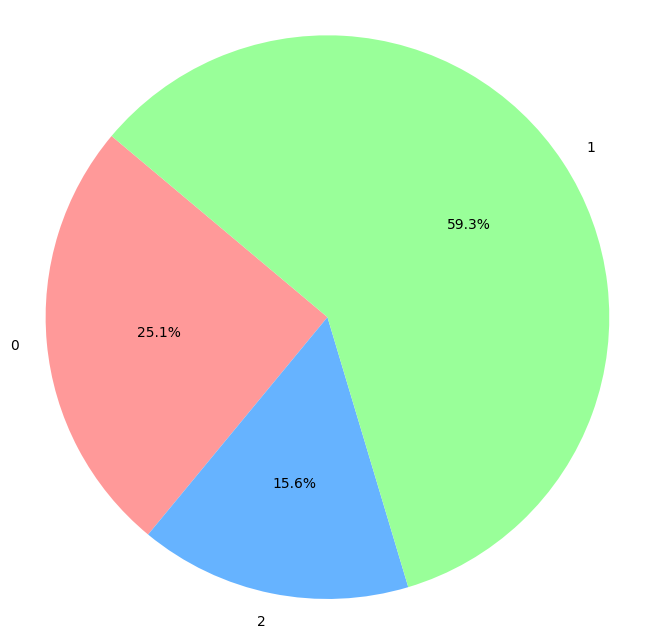

In [31]:
counter = Counter(df2['Emotion'])
labels = counter.keys()
sizes = counter.values()

# warna
colors = ['#ff9999','#66b3ff','#99ff99']

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)

plt.axis('equal')
plt.show()

---
Interpretasi:

Pie chart di atas menunjukkan pola persebaran label pada data hasil scrapping twitter. Dengan mengingat bahwa labeling 0 menunjukkan reaksi negati, 1 menunjukkan reaksi netral, dan 2 menunjukkan reaksi positif didapatkan bahwa terdapat kesenjangan proporsi untuk setiap kelas dimana proporsi dengan label 1 (netral) mendominasi hasil scrapping twitter karena mencapai 59,3%. Diikuti dengan reaksi negatif

In [32]:
def plot_wordcloud_and_frequency(df, text_column, label_column, stopwords = sw_id, num_word = 10):
    labels = df[label_column].unique()
    num_cols = 2

    for label in labels:
        fig, axes = plt.subplots(1, num_cols, figsize=(12, 6))

        # Filter
        text = " ".join(df[df[label_column] == label][text_column])

        # Membuat wordcloud
        wordcloud = WordCloud(width=400, height=400,
                              background_color='white',
                              stopwords=stopwords,
                              min_font_size=10,
                              colormap='viridis').generate(text)

        # Menampilkan wordcloud
        axes[0].imshow(wordcloud)
        axes[0].axis("off")
        axes[0].set_title(f'WordCloud - {label}')

        # Menghitung frekuensi tiap kata
        text_data = df[df[label_column] == label][text_column]
        word_frequency = text_data.str.split(expand=True).stack().value_counts()
        freq = word_frequency.head(num_word) # adjust numbers of word

        # Menampilkan frekuensi tiap kata
        sns.barplot(x=freq.values, y=freq.index, ax=axes[1], palette="muted")
        axes[1].set_title(f'Word Frequency - {label}')
        axes[1].set_xlabel('Count')
        for p in axes[1].patches:
            axes[1].annotate("{:.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + .5), ha='left', va='center')

        plt.tight_layout()
        plt.show()

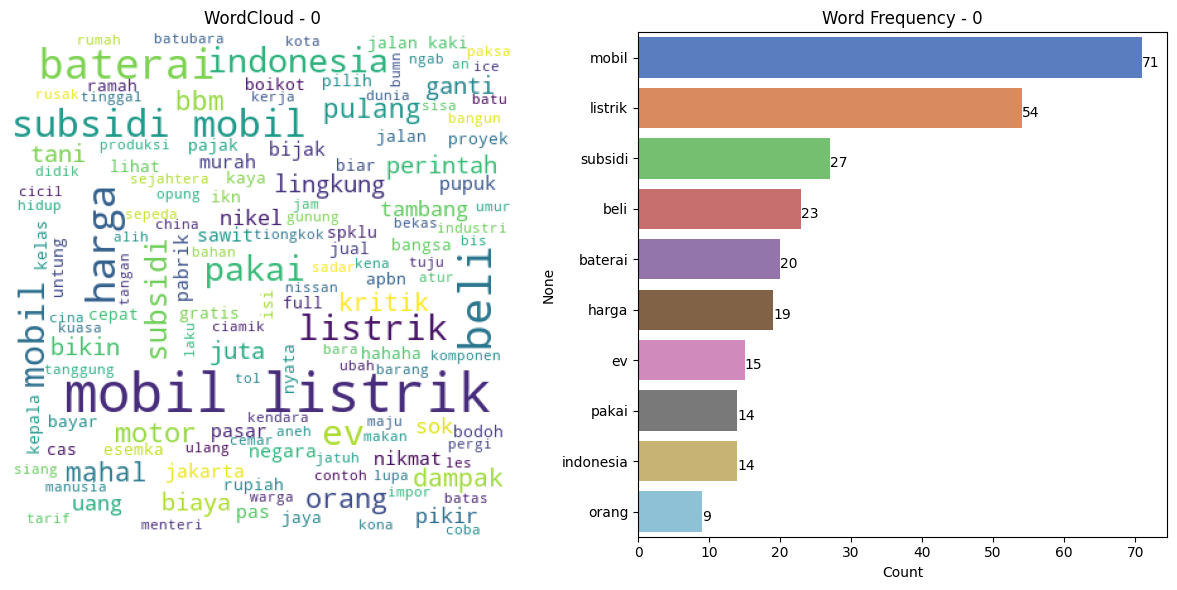

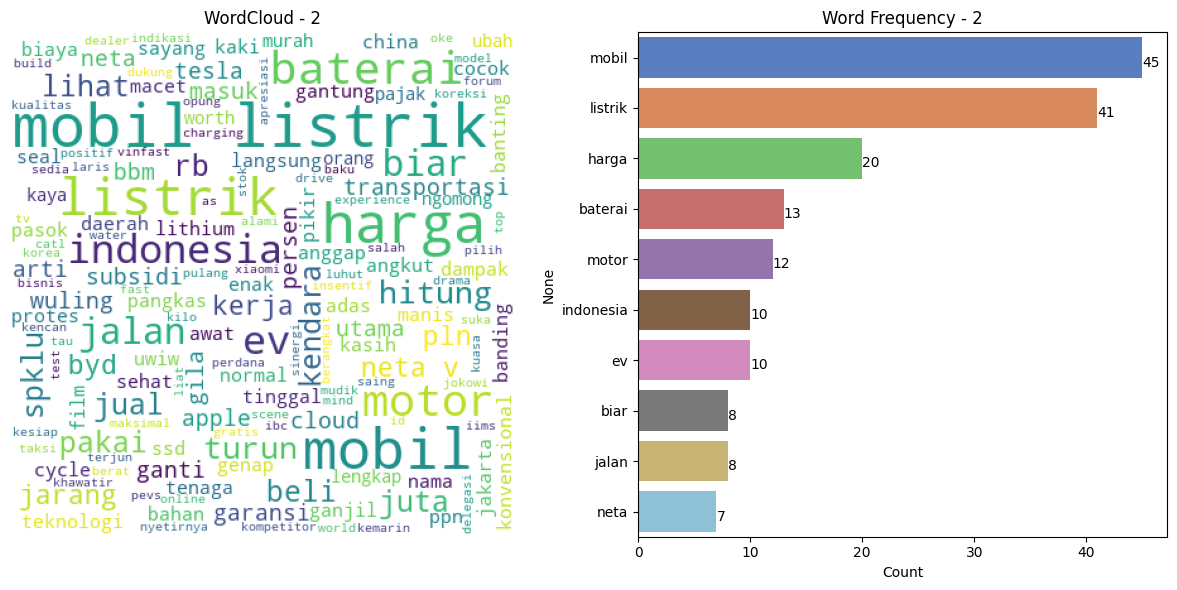

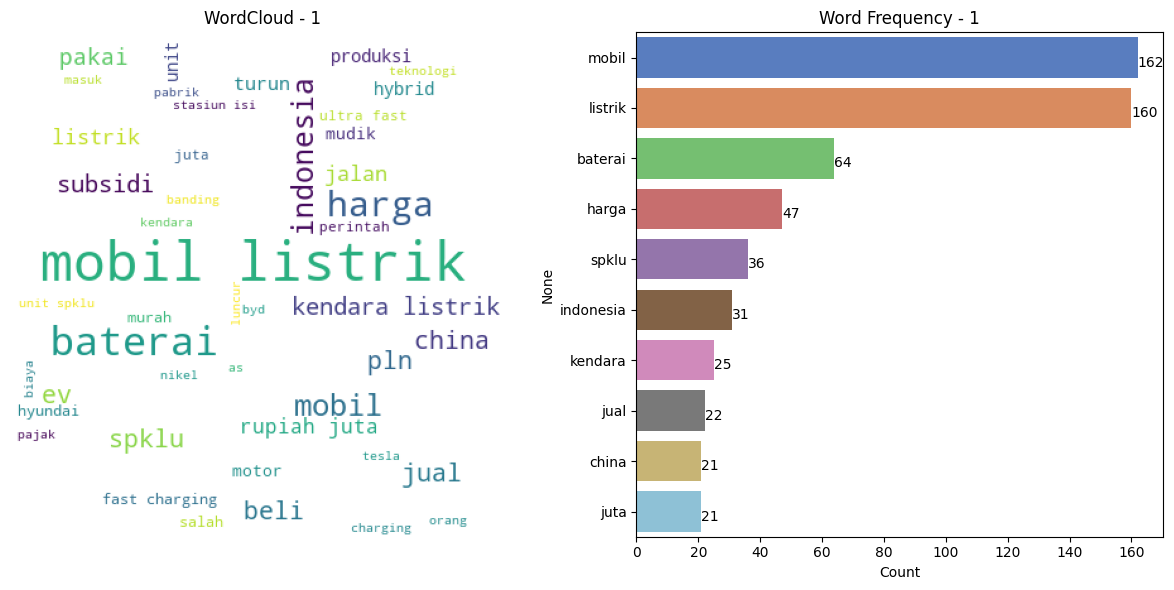

In [33]:
plot_wordcloud_and_frequency(df1_pre, 'tweet', 'Emotion', sw_id, 10)

# 6 - Kesimpulan

Dari analisis yang dilakukan didapatkan bahwa kebanyakan dari netizen memiliki sentimen yang netral (59,3%) dimana kaat yang sering muncul adalah baterai, harga, SPKLU (stasiun isi) dan Indonesia (mengecualikan mobil dan listrik karena label kelas mengandung kata ini sebagai kata tertingginya dan memang topik ini yang dibicarakan). Secara intuitif dapat diperkirakan bahwa kebanyakan netizen masih ragu-ragu dan belum bisa menyatakan dukungan atau bantahan terkait kebijakan ini. Netizen masih bertanya-tanya mengenai keberlangsungan kendaraan listrik di Indonesia termasuk bagaimana keadaan stasiun isi, harganya, dan lainnya.

Selanjutnya sentimen netizen juga cenderung menunjukkan ketidaksetujuan terhadap kebijakan kendaraan listrik (25,1%) dimana kebanyakan sentimen netral memiliki kata-kata yang sering muncul yaitu subsidi, mahal, kritik, dampak, cemar, beli, baterai dan harga (mengecualikan mobil dan listrik karena label kelas mengandung kata ini sebagai kata tertingginya dan memang topik ini yang dibicarakan). Secara intuitif dapat dikatakan bahwanetizen memiliki sentimen yang negatif terhadap dampak dari keberadaan kendaraan listrik di indonesia. Dimana tidak sedikit yang membicarakan mengenai harganya yang mahal, memberi dampak buruk ke lingkungan, kecenderungan negatif terhadap kebijakan subsidi, dan lainnya.

Hanya sedikit netizen yang memiliki sentimen positif terhadap kebijakan kendaraan listrik ini (15,6%) saja dimana kebanyakan membicarakan mengenai subsidi, garansi, jual, harga, pajak (mengecualikan mobil dan listrik karena label kelas mengandung kata ini sebagai kata tertingginya dan memang topik ini yang dibicarakan). Artinya sebagian netizen juga memiliki cara pandang berbeda terhadap kebijakan subsidi (mendukung), pengadaan garansi bagi kendaraan listrik, harga yang pas, dan kebijakan pajak bagi kendaraan listrik. sebagian netizen mendukung hal ini walau masih sedikit.

